# Neural Machine Translation with a transformer model

In this tutorial you'll learn how to create and train a transformer model to translate from english to deutsch using the Multi30k dataset.

Details:
* Framework: PyTorch
* Model: Transformer
* Task: Language Translation (en->de) 
* Packages: Torchtext, SpaCy
* Dataset: Multi30k

Installs: to run this tutorial, first install TorchText and SpaCy typing the following commands in your environment:

```
#Upgrade pip
pip install --upgrade pip

#Install torchtext
pip install torchtext

#Install spacy
conda install spacy # or pip install spacy

#Download English and German tokenizers
python -m spacy download en
python -m spacy download de
```

# Imports

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator, Iterator

import numpy as np
import matplotlib.pyplot as plt

import math
import time

print(f'Torch version: {torch.__version__}')

Torch version: 1.4.0


# 1. Model

In [2]:
class TransformerModel(nn.Module):
    def __init__(self,
                 src_vocab_size: int,
                 trg_vocab_size: int,
                 d_model: int,
                 num_heads: int,
                 num_enc_layers: int,
                 num_dec_layers: int,
                 ffn_size: int,
                 dropout: float,
                 activation: str):
        
        #super(TransformerModel, self).__init__()
        super().__init__()
        
        self.d_model = d_model

        # Embeddings
        self.enc_embedding = nn.Embedding(num_embeddings = src_vocab_size, 
                                          embedding_dim = d_model)
        self.dec_embedding = nn.Embedding(num_embeddings = trg_vocab_size,
                                          embedding_dim = d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # Custom encoder
        #encoder_layer = TransformerEncoderLayer(d_model, num_heads, ffn_size, dropout, activation)
        #encoder_norm = nn.LayerNorm(d_model)
        #self.encoder = TransformerEncoder(encoder_layer, num_enc_layers, encoder_norm)
        
        # Custom decoder
        #decoder_layer = TransformerDecoderLayer(d_model, num_heads, ffn_size, dropout, activation)
        #decoder_norm = nn.LayerNorm(d_model)
        #self.decoder = TransformerDecoder(decoder_layer, num_dec_layers, decoder_norm)
        
        # Transformer
        self.transformer = nn.Transformer(d_model = d_model, 
                                          nhead = num_heads,
                                          num_encoder_layers = num_enc_layers,
                                          num_decoder_layers = num_dec_layers,
                                          dim_feedforward = ffn_size,
                                          dropout = dropout,
                                          activation = activation,
                                          custom_encoder = None, #self.encoder,
                                          custom_decoder = None) #self.decoder)
        
        # Linear layer
        self.fc = nn.Linear(d_model, trg_vocab_size)
        
        # Initialize weights
        self.init_weights() # default: normal(0,1)


    def init_weights(self):
        #self.enc_embedding.weight.data.normal_(mean=0.0, std=1.0)
        #self.dec_embedding.weight.data.normal_(mean=0.0, std=1.0)
        nn.init.normal_(self.enc_embedding.weight, mean=0.0, std=1.0)
        nn.init.normal_(self.dec_embedding.weight, mean=0.0, std=1.0)
        
        
    def forward(self, src: torch.tensor, trg: torch.tensor):
        src = self.enc_embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)

        trg = self.dec_embedding(trg) * math.sqrt(self.d_model)
        trg = self.pos_encoder(trg)

        output = self.transformer(src, trg)
        output = self.fc(output)

        return output

In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# 2. Train, evaluate and inference functions

In [4]:
def train(model: nn.Module,
          iterator: BucketIterator,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip_value: float):
    
    model.train() # Turn on the training mode

    loss_sum = 0

    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
            #src: [src_len, batch_size]
            #trg: [trg_len, batch_size]
    
        src = src.to(device)
        trg = trg.to(device)

        output = model(src = src[:,:], trg = trg[:-1,:])
            # output: [trg_len-1, batch_size, trg_vocab_size]
        
        loss =  criterion(output.view(-1, output.shape[2]), trg[1:,:].view(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        
        loss_sum += loss.item()

    epoch_loss = loss_sum / len(iterator)
    return epoch_loss

In [5]:
def evaluate(model: nn.Module,
             iterator: BucketIterator,
             criterion: nn.Module):
    
    model.eval() # Turn on the evaluation mode
    
    loss_sum = 0
    
    with torch.no_grad():

        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
                #src: [src_len, batch_size]
                #trg: [trg_len, batch_size]

            src = src.to(device)
            trg = trg.to(device)

            output = model(src = src[:,:], trg = trg[:-1,:])
                # output: [trg_len-1, batch_size, trg_vocab_size]

            loss =  criterion(output.view(-1, output.shape[2]), trg[1:,:].view(-1))

            loss_sum += loss.item()

        epoch_loss = loss_sum / len(iterator)
    return epoch_loss

In [6]:
def inference(src: torch.tensor,
              trg: torch.tensor,
              model: nn.Module,
              criterion: nn.Module):
    
    model.eval() # Turn on the evaluation mode
    
    with torch.no_grad():
            #src: [src_len, batch_size]
            #trg: [trg_len, batch_size]
    
        src = src.to(device)
        trg = trg.to(device)
        
        output = model(src = src[:,:], trg = trg[:-1,:])
            #output: [trg_len-1, batch_size, trg_vocab_size]

        loss =  criterion(output.view(-1, output.shape[2]), trg[1:,:].view(-1))
   
        #Predictions
        preds = torch.argmax(output.permute(1, 0, 2), dim = 2)
        preds_words = []
        for sent in preds:
            sent_words = []
            for token in sent:
                if token == TRG.vocab.stoi['<eos>']:
                    break
                else:
                    sent_words.append(TRG.vocab.itos[token])
            preds_words.append(sent_words)

        #Targets
        trgs_words = []
        for sent in trg.permute(1,0)[:,1:]:
            sent_words = []
            for token in sent:
                if token == TRG.vocab.stoi['<eos>']:
                    break
                else:
                    sent_words.append(TRG.vocab.itos[token])
            trgs_words.append(sent_words)
        
        #Sources
        srcs_words = []
        for sent in src.permute(1,0)[:,:]:
            sent_words = []
            for token in sent:
                if token == SRC.vocab.stoi['<eos>']:
                    break
                else:
                    sent_words.append(SRC.vocab.itos[token])
            srcs_words.append(sent_words)

        for i in range(len(preds_words)):
            print(f"\nsrc:\t {' '.join([token for token in srcs_words[i]])}")
            print(f"trg:\t {' '.join([token for token in trgs_words[i]])}")
            print(f"pred:\t {' '.join([token for token in preds_words[i]])}")
    
    return loss

In [7]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
def epoch_time(start_time: int, end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# 3. Run the model

In [9]:
# Hyperparameters
tutorial_name = 'nmt_transformer_multik30'

BATCH_SIZE = 32
NUM_EPOCHS = 50

LR = 0.001
CLIP_VALUE = 1

D_MODEL = 100 #in the original paper 512
NUM_HEADS = 2 #in the original paper 8
NUM_ENC_LAYERS = 2 #in the original paper 6 
NUM_DEC_LAYERS = 2 #in the original paper 6
FFN_SIZE = 512 #in the original paper 2048
DROPOUT_PROB = 0.1 #in the original paper 0.1

In [10]:
# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda


In [11]:
# Fields
SRC = Field(tokenize = "spacy",
            tokenizer_language="de",
            sequential = True,
            use_vocab = True,
            init_token = None, 
            eos_token = '<eos>',
            fix_length = None,
            dtype = torch.long,
            lower = True,
            include_lengths = False,
            batch_first = False,
            pad_token = "<pad>",
            unk_token = "<unk>")

TRG = Field(tokenize = "spacy",
            tokenizer_language="en",
            sequential = True,
            use_vocab = True,
            init_token = '<sos>', 
            eos_token = '<eos>',
            fix_length = None,
            dtype = torch.long,
            lower = True,
            include_lengths = False,
            batch_first = False,
            pad_token = "<pad>",
            unk_token = "<unk>")

fields = [('src', SRC), ('trg', TRG)]

In [12]:
# Load dataset
train_data, dev_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                  fields = fields)

print(f'train_data size: {len(train_data)}')
print(f'dev_data size: {len(dev_data)}')
print(f'test_data size: {len(test_data)}')

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 454kB/s] 


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 113kB/s] 


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 93.9kB/s]


train_data size: 29000
dev_data size: 1014
test_data size: 1000


In [13]:
# Vocabulary
SRC.build_vocab(train_data,
                max_size = None,
                min_freq = 2,
                vectors = None)

TRG.build_vocab(train_data,
                max_size = None,
                min_freq = 2,
                vectors = None)

print(f'src_vocab_size: {len(SRC.vocab)}')
print(f'trg_vocab_size: {len(TRG.vocab)}')

src_vocab_size: 7854
trg_vocab_size: 5893


In [14]:
# Iterators
iterators = BucketIterator.splits((train_data, dev_data, test_data),
                                    batch_size = BATCH_SIZE,
                                    sort_key = lambda x: len(x.src),
                                    device = None,
                                    shuffle = True)
train_iterator, dev_iterator, test_iterator = iterators

In [15]:
# Initialize the model
model = TransformerModel(src_vocab_size = len(SRC.vocab),
                         trg_vocab_size = len(TRG.vocab),
                         d_model = D_MODEL,
                         num_heads = NUM_HEADS,
                         num_enc_layers = NUM_ENC_LAYERS,
                         num_dec_layers = NUM_DEC_LAYERS,
                         ffn_size = FFN_SIZE,
                         dropout = DROPOUT_PROB,
                         activation = 'relu')

# Move model to the device
model = model.to(device)
#print(model)

In [16]:
# Parameters
num_parameters = count_parameters(model)
print(f'\nnum_parameters: {num_parameters}')


num_parameters: 2626741


In [17]:
# Loss (CrossEntropyLoss calculates both nn.LogSoftmax() and nn.NLLLoss() )
PAD_IDX = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [18]:
# Optimizer
optimizer = optim.Adam(params = model.parameters(), lr = LR)

In [19]:
# Training loop
print('\nTraining:')

train_loss_history = []
dev_loss_history = []
best_dev_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    
    start_time = time.time()

    train_loss = train(model = model,
                       iterator = train_iterator,
                       optimizer = optimizer,
                       criterion =  criterion,
                       clip_value = CLIP_VALUE)
  
    dev_loss = evaluate(model = model,
                        iterator = dev_iterator,
                        criterion =  criterion)
    
    train_loss_history.append(train_loss)
    dev_loss_history.append(dev_loss)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        torch.save(model.state_dict(), 'saved_models/'+tutorial_name+'.pt')
    
    #if epoch+1 == 1 or (epoch+1) % 10 == 0:
    print('-' * 80)
    print(f'Epoch: {epoch+1:03} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain loss: {train_loss:.4f} | Train PPL: {math.exp(train_loss):7.4f}')
    print(f'\tDev loss:   {dev_loss:.4f} | Dev PPL:   {math.exp(dev_loss):7.4f}')


Training:
--------------------------------------------------------------------------------
Epoch: 001 | Time: 0m 22s
	Train loss: 3.9255 | Train PPL: 50.6791
	Dev loss:   2.9434 | Dev PPL:   18.9794
--------------------------------------------------------------------------------
Epoch: 002 | Time: 0m 21s
	Train loss: 2.9142 | Train PPL: 18.4342
	Dev loss:   2.3481 | Dev PPL:   10.4657
--------------------------------------------------------------------------------
Epoch: 003 | Time: 0m 21s
	Train loss: 2.4301 | Train PPL: 11.3604
	Dev loss:   2.0198 | Dev PPL:    7.5372
--------------------------------------------------------------------------------
Epoch: 004 | Time: 0m 21s
	Train loss: 2.1237 | Train PPL:  8.3623
	Dev loss:   1.8371 | Dev PPL:    6.2784
--------------------------------------------------------------------------------
Epoch: 005 | Time: 0m 21s
	Train loss: 1.9136 | Train PPL:  6.7777
	Dev loss:   1.6810 | Dev PPL:    5.3710
--------------------------------------------

# 4. Learning curves

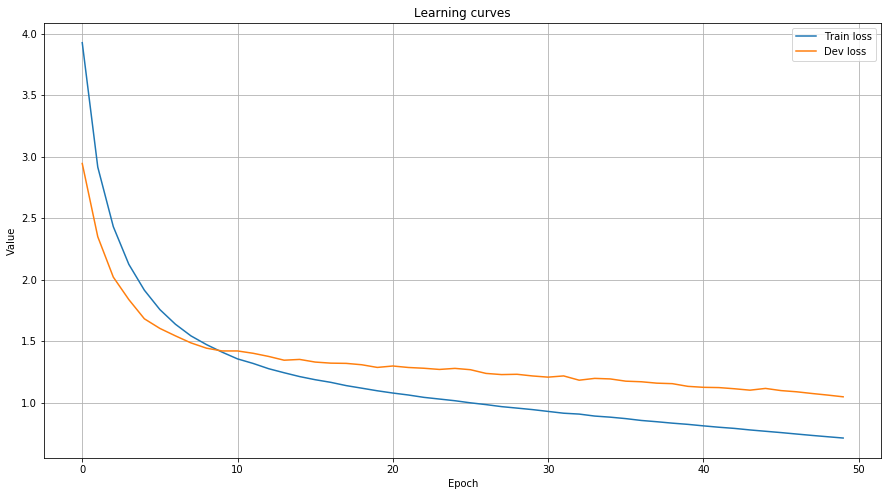

In [20]:
plt.figure(figsize=(15,8))
plt.grid(b=True)
plt.plot(train_loss_history, label='Train loss')
plt.plot(dev_loss_history, label='Dev loss')
plt.title('Learning curves')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend()

In [21]:
# Best dev loss
min_dev_loss = min(dev_loss_history)
epoch = np.argmin(dev_loss_history)+1
print(f'min_dev_loss: {min_dev_loss} , epoch: {epoch}')

min_dev_loss: 1.0467741768807173 , epoch: 50


# 5. Evaluation

In [23]:
test_loss = evaluate(model = model,
                     iterator = test_iterator,
                     criterion =  criterion)
    
print(f'Test loss: {test_loss:.4f} | Test PPL: {math.exp(test_loss):7.4f}')

Test loss: 1.0557 | Test PPL:  2.8740


# 6. Inference

Take some test examples and check the trained model's output

In [24]:
# Load bests model
model.load_state_dict(torch.load('saved_models/'+tutorial_name+'.pt'))

# Iterator
infer_test_iterator = Iterator(test_data,
                                 batch_size = 10,
                                 sort_key = lambda x: len(x.src),
                                 device = None,
                                 shuffle = True,
                                 sort = False)
#print(model)

In [25]:
batch = next(iter(infer_test_iterator))
src = batch.src
trg = batch.trg
    #src: [src_len, batch_size]
    #trg: [trg_len, batch_size]

loss = inference(src, trg, model, criterion)
print(f'\nloss: {loss}')


src:	 ein mann in einem roten hemd betritt ein <unk> .
trg:	 a man in a red shirt entering an establishment .
pred:	 a man in a red shirt entering an establishment .

src:	 zwei junge männer fahren auf einem sehr kleinen wagen voller kartoffeln , der von einem pferd gezogen wird .
trg:	 two young men riding on a very small horse - drawn wagon full of potatoes .
pred:	 two young men riding on a very small wagon drawn drawn of full of potatoes .

src:	 der hund mit dem roten halsband knurrt den hund mit dem blauen halsband an .
trg:	 the dog with the red collar is <unk> its teeth at the dog with the blue collar .
pred:	 the dog with the collar collar is <unk> at collar . the dog with the blue collar is

src:	 eine frau in einem <unk> mantel steht vor einer <unk> <unk> und macht eine grimasse in richtung einer frau in einem violetten mantel .
trg:	 a woman wearing a bright pink overcoat makes a face to a woman wearing a purple overcoat while standing outside a <unk> <unk> .
pred:	 a woma

# That's it!